# Regression
*By Joe Tungate*

In this notebook, a regression model is built using the ftlogic package. The purpose of this task is to demonstrate ftlogic applied to a more complex task than simple binary classification.

In [1]:
import ftlogic.core as ftl
import ftlogic.fuzzyops as fops
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

## Data Processing
For this task, the California Housing Price dataset is used.  The 'small' version of the dataset is used consisting of 600 samples. Each sample is an eight dimensional feature vector encoding the following properties:
- MedInc - median income in block group,
- HouseAge - median house age in block group,
- AveRooms - average number of rooms per household,
- AveBedrms - average number of bedrooms per household,
- Population - block group population,
- AveOccup - average number of household members,
- Latitude - block group latitude,
- Longitude -  block group longitude.

Each sample has an associated scalar label, representing the house price.

This example splits the dataset into train and test sets with a ratio of 0.8.

In [2]:
(xTrain, yTrain), (xTest, yTest) = (
    keras.datasets.california_housing.load_data(version="small", test_split=0.2)
)

yTrain = np.reshape(yTrain, (len(yTrain), 1))
yTest = np.reshape(yTest, (len(yTest), 1))

We perform feature-wise normalisation on the dataset. We calculate the mean and standard deviation only on the train set to prevent information leaks. Additionally, the house prices are scaled to be in tens of thousands of dollars.

In [3]:
trainMean = xTrain.mean(axis=0)
xTrain -= trainMean
xTest -= trainMean

trainStd = xTrain.std(axis=0)
xTrain /= trainStd
xTest /= trainStd

In [4]:
yTrain /= 10000
yTest /= 10000

In [5]:
x = np.vstack((xTrain, xTest)).astype(np.float32)
y = np.vstack((yTrain, yTest)).astype(np.float32)

## Defining the System

We now define the FTL system. Our signature consists of a predicate Equal(x, y) calculating the simularity between house price values, a functor price(x) which predicts the house price of a sample, and a functor label(x) which returns the label of a sample. In the structure, Equal and label will be symbolic entities and price will be neural. 

### Signature and Knowledge Base

In [6]:
sig = ftl.Signature(
    predicates={"Equal": 2},
    functors={"price": 1, "label": 1}
)

In [7]:
kb = ftl.KnowledgeBase(
    signature=sig,
    formulas=[
        "Ax~P:Equal(price(x), label(x))"
    ],
)

### Structure and Interpretation
We now map our symbols to actual tensors and functions.

In [8]:
labeldict = dict()
for i, sample in enumerate(x):
    labeldict[str(x[i:i+1])] = y[i:i+1]

def label(x):
    return labeldict[str(x)]

In [9]:
price = keras.Sequential([
    keras.Input((8,)),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(1)
])


In [10]:
def equal(x, y):
    return tf.math.exp(-0.05 * tf.math.sqrt(tf.math.square(x - y)))

In [11]:
struc = ftl.Structure(
    signature=sig,
    mappings={
        "Equal": equal,
        "price": price,
        "label": label}
)

In [12]:
interp = ftl.Interpretation(
    structure=struc, 
    variableAssignment={},
    domainAssignment={
        "D": x,
        "P": xTrain,
        "Q": xTest}
)

### The Model
We now compile and train the model. We train for 200 epochs using RMSprop as the optimiser and the Standard Product Set universal quantifer as the satisfaction aggregator. We use a learning rate of 0.01. Furthermore, we use L2 regularisation with an l2 of 0.0001 to combat overfitting. Finally, we included a validation knowledge base to track training performance on the test set.

In [13]:
model = ftl.Model(
    knowledgeBase=kb,
    interpretation=interp,
    operatorSet=fops.standardProductSet
)

In [14]:
def l2reg(trainables):
    reg = keras.regularizers.L2(0.0001)
    errors = tf.Variable(tf.constant(0.))
    for weight in trainables:
        errors.assign_add(reg(weight))

    return errors

In [15]:
history = model.fit(
    epochs=200,
    optimiser=keras.optimizers.RMSprop(learning_rate=0.01),
    aggregator=fops.standardProductSet.universal,
    trainables=price.trainable_weights,
    regulariser=l2reg,
    validationKB = ftl.KnowledgeBase(sig, ["Ax~Q:Equal(price(x), label(x))"])
)

Training model for 200 epochs.
epoch 1 / 200. 
loss: [[0.6161025]], 
satisfaction: [[0.37593043]].
epoch 2 / 200. 
loss: [[0.5999889]], 
satisfaction: [[0.39204144]].
epoch 3 / 200. 
loss: [[0.581701]], 
satisfaction: [[0.41018343]].
epoch 4 / 200. 
loss: [[0.55385953]], 
satisfaction: [[0.43775487]].
epoch 5 / 200. 
loss: [[0.5128051]], 
satisfaction: [[0.47839844]].
epoch 6 / 200. 
loss: [[0.46296713]], 
satisfaction: [[0.52769184]].
epoch 7 / 200. 
loss: [[0.41714406]], 
satisfaction: [[0.5729468]].
epoch 8 / 200. 
loss: [[0.37746188]], 
satisfaction: [[0.6122046]].
epoch 9 / 200. 
loss: [[0.3384445]], 
satisfaction: [[0.65096116]].
epoch 10 / 200. 
loss: [[0.2999445]], 
satisfaction: [[0.6892875]].
epoch 11 / 200. 
loss: [[0.26568112]], 
satisfaction: [[0.7234376]].
epoch 12 / 200. 
loss: [[0.24544598]], 
satisfaction: [[0.7436418]].
epoch 13 / 200. 
loss: [[0.23479052]], 
satisfaction: [[0.75424373]].
epoch 14 / 200. 
loss: [[0.22790109]], 
satisfaction: [[0.7611974]].
epoch 15 / 

### Results
We plot and inspect the loss and satisfaction.

In [16]:
loss = [x.numpy()[0] for x in history['loss']]
satisfaction = [x.numpy()[0] for x in history['satisfaction']]
val_sat = [x.numpy()[0] for x in history['validation_satisfaction'][0]]

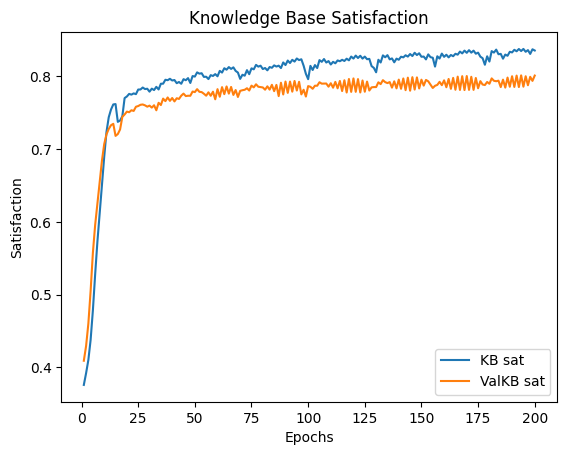

In [17]:
epochs = np.arange(1, 201)
plt.plot(epochs, satisfaction, label="KB sat")
plt.plot(epochs, val_sat, label="ValKB sat")
plt.xlabel("Epochs")
plt.ylabel("Satisfaction")
plt.title("Knowledge Base Satisfaction")
plt.legend()
plt.show()

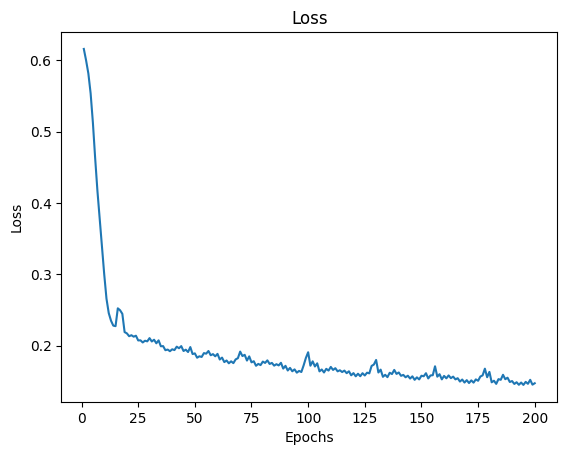

In [18]:
plt.plot(epochs, loss)
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [19]:
print(f"Loss at epoch 200: {loss[-1]}")

Loss at epoch 200: [0.14704461]


In [20]:
print(f"kb satisfaction at epoch 200: {satisfaction[-1]}")

kb satisfaction at epoch 200: [0.83529276]


In [21]:
print(f"validation kb satisfaction at epoch 200: {val_sat[-1]}")

validation kb satisfaction at epoch 200: [0.800846]


Finally, we calculate the mean absolute error.

In [22]:
predictions = price.predict(xTest)
mae = keras.metrics.MeanAbsoluteError()
mae.update_state(yTest, predictions)
mae.result()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=3.558726>